# Mounting Drive 

In [ ]:
# Load the Drive helper and mount
from google.colab import drive

# This will prompt for authorization
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# After executing the cell above, Drive
# files will be present in "/content/drive/My Drive".
!ls "/content/drive/My Drive/Emotion Speech Recognition"
!cd "/content/drive/My Drive/Emotion Speech Recognition"
!ls

Dataset  utils
dataset_attr.csv  drive  sample_data


#  Installation of Dependencies



Essential requirement of of our project :
1. **Python 3.7**
2. **Librosa**
3. **PyTorch**
4. **Keras**
5. **GPU**

We have Already installed this frameworks and packages.

In [ ]:
# Provides a way of using operating system dependent functionality. 
import os

# LibROSA provides the audio analysis
import librosa
# Need to implictly import from librosa
import librosa.display

# Import the audio playback widget
import IPython.display as ipd
from IPython.display import Image

# Enable plot in the notebook
%pylab inline
%matplotlib inline
import matplotlib.pyplot as plt

# These are generally useful to have around
import numpy as np
import pandas as pd


# To build Neural Network and Create desired Model
import keras
from keras.models import Model
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D #, AveragePooling1D
from keras.layers import Flatten, Dropout, Activation # Input, 
from keras.layers import Dense #, Embedding
from keras.utils import np_utils
from sklearn.preprocessing import LabelEncoder

Populating the interactive namespace from numpy and matplotlib


# 3. Data Preparation


### Plotting the audio file's waveform and its spectrogram

In [ ]:
#data, sampling_rate = librosa.load('/content/drive/My Drive/Emotion Speech Recognition/Dataset/anger/anger016.wav')
data, sampling_rate = librosa.load('/content/drive/MyDrive/Emotion Speech Recognition/Dataset/anger/anger016.wav')
# To play audio this in the jupyter notebook
ipd.Audio('/content/drive/MyDrive/Emotion Speech Recognition/Dataset/anger/anger016.wav')

In [ ]:
len(data)

87553

In [ ]:
sampling_rate

22050

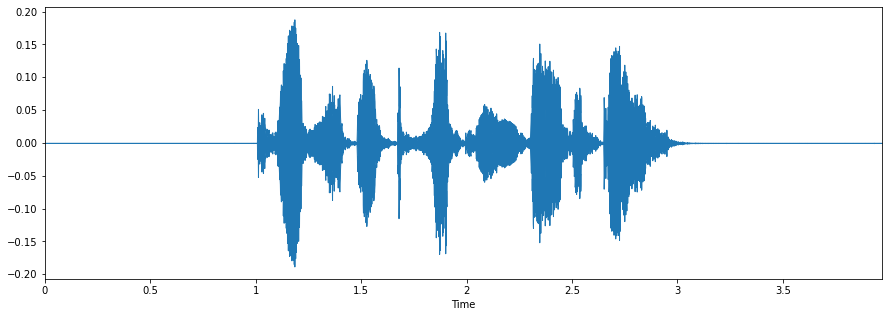

In [ ]:
plt.figure(figsize=(15, 5))
librosa.display.waveplot(data, sr=sampling_rate)

### Setup the Basic Paramter

In [ ]:
dataset_path = os.path.abspath('./Dataset')
destination_path = os.path.abspath('./')
# To shuffle the dataset instances/records
randomize = True
# for spliting dataset into training and testing dataset
split = 0.8
# Number of sample per second e.g. 16KHz
sampling_rate = 20000 
emotions=["anger","disgust","fear","happy","neutral", "sad", "surprise"]

!ls


drive  sample_data


### Converting Dataset in CSV format

it will cause easy operation on Dataset.

In [ ]:
!pip install datasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
#from datasets import dataset_utils

In [ ]:
# import required libraries
import os
import sys
import csv
import librosa
import numpy as np
import pandas as pd
from PIL import Image
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
np.random.seed(42)

def create_meta_csv(dataset_path, destination_path):
    """Create a meta csv file given a dataset folder path of Audio.
    
    This function creates and saves a meta csv file named 'dataset_attr.csv' given a dataset folder path of audios.
    The file will contain audios and their labels. This file can be then used to make
    train, test and val splits, randomize them and load few of them (a mini-batch) in memory
    as required. The file is saved in dataset_path folder if destination_path is not provided.
    
    Args:
        dataset_path (str): Path to dataset folder
        destination_path (str): Destination to store meta file if None provided, it'll store file in dataset_path

    Returns:
        True (bool): Returns True if 'dataset_attr.csv' was created successfully else returns an exception
    """
    # Change dataset path accordingly
    DATASET_PATH = os.path.abspath(dataset_path)
    csv_path=os.path.join(destination_path, 'dataset_attr.csv')
    flist = []
    emotions=["anger","disgust","fear","happy","neutral", "sad", "surprise"]
    for root, dirs, files in os.walk(DATASET_PATH, topdown=False):
        for name in files:
            if (name.endswith('.wav')): 
                fullName = os.path.join(root, name)
                flist.append(fullName)

    split_format = str('/') if sys.platform=='linux' else str('\\')
    
    filenames=[]
    for idx,file in enumerate(flist):
        filenames.append(file.split(split_format)) 
        # print(filenames[idx])
    types=[]
    for idx,path in enumerate(filenames):
        types.append((flist[idx],emotions.index(path[-2]))) ##second last location has emotion name

    with open(csv_path, 'w') as f:
        writer = csv.writer(f)
        writer.writerows([("path","label")])
        writer.writerows(types)
    f.close()
    # change destination_path to DATASET_PATH if destination_path is None 
    if destination_path == None:
        destination_path = DATASET_PATH
        # write out as dataset_attr.csv in destination_path directory
        # if no error
    return True

def create_and_load_meta_csv_df(dataset_path, destination_path, randomize=True, split=None):
    """Create a meta csv file given a dataset folder path of audios and loads it as a pandas dataframe.

    This function creates and saves a meta csv file named 'dataset_attr.csv' given a dataset folder path of audios.
    The function will return pandas dataframes for the csv and also train and test splits if you specify a 
    fraction in split parameter.
    
    Args:
        dataset_path (str): Path to dataset folder
        destination_path (str): Destination to store meta csv file
        randomize (bool, optional): Randomize the csv records. Defaults to True
        split (double, optional): Percentage of train records. Defaults to None

    Returns:
        dframe (pandas.Dataframe): Returns a single Dataframe for csv if split is none, else returns more two Dataframes for train and test splits.
        train_set (pandas.Dataframe): Returns a Dataframe of length (split) * len(dframe)
        test_set (pandas.Dataframe): Returns a Dataframe of length (1 - split) * len(dframe)
    """
    if create_meta_csv(dataset_path, destination_path=destination_path):
        dframe = pd.read_csv(os.path.join(destination_path, 'dataset_attr.csv'))

    # shuffle if randomize is True or if split specified and randomize is not specified 
    # so default behavior is split
    if randomize == True or (split != None and randomize == None):
        # shuffle the dataframe here
        dframe=dframe.sample(frac=1).reset_index(drop=True)
        pass

    if split != None:
        train_set, test_set = train_test_split(dframe, split)
        return dframe, train_set, test_set 
    
    return dframe

def train_test_split(dframe, split_ratio):
    """Splits the dataframe into train and test subset dataframes.

    Args:
        split_ration (float): Divides dframe into two splits.

    Returns:
        train_data (pandas.Dataframe): Returns a Dataframe of length (split_ratio) * len(dframe)
        test_data (pandas.Dataframe): Returns a Dataframe of length (1 - split_ratio) * len(dframe)
    """
    # divide into train and test dataframes
    train_data= dframe.iloc[:int((split_ratio) * len(dframe)), :]
    test_data= dframe.iloc[int((split_ratio) * len(dframe)):,:]
    test_data=test_data.reset_index(drop=True) #reset index for test data
    return train_data, test_data

if __name__ == "__main__":
    # test config
    dataset_path =  os.path.dirname(os.getcwd())+'/Dataset'
    print("dataset_path : ", dataset_path)
    destination_path = os.getcwd()
    classes = 7
    total_rows = 2556
    randomize = True
    clear = True

    # test_create_meta_csv()
    df, trn_df, tst_df = create_and_load_meta_csv_df(dataset_path, destination_path=destination_path, randomize=randomize, split=0.99)
    print(df.describe())
    print(trn_df.describe())
    print(tst_df.describe())

dataset_path :  //Dataset
       path label
count     0     0
unique    0     0
top     NaN   NaN
freq    NaN   NaN
       path label
count     0     0
unique    0     0
top     NaN   NaN
freq    NaN   NaN
       path label
count     0     0
unique    0     0
top     NaN   NaN
freq    NaN   NaN


In [ ]:
!pip install utils

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
#from utils import dataset

In [ ]:
!ls "/content/drive/MyDrive/Emotion Speech Recognition/utils"

'Copy of dataset.py'   feature_extraction.py   __pycache__
 dataset.py	       images


In [ ]:
!cd "/content/drive/MyDrive/Emotion Speech Recognition/utils"

In [ ]:
##/content/drive/MyDrive/Emotion Speech Recognition/utils
# loading dataframes using dataset module 
#!cd "/content/drive/MyDrive/Emotion Speech Recognition/utils"
#import dataset
# To know more about "create_and_load_meta_csv_df" function and it's working, go to "./utils/dataset.py" script. 
#df, train_df, test_df = dataset.create_and_load_meta_csv_df(dataset_path, destination_path, randomize, split)

In [ ]:
df=pd.read_csv('/content/drive/MyDrive/Emotion Speech Recognition/Dataset/dataset_attr1.csv')

In [ ]:
#df, train_df, test_df = (df, randomize, split)

In [ ]:
#print('Dataset samples  : ', len(df),"\nTraining Samples : ", len(train_df),"\ntesting Samples  : ", len(test_df))

# 4. Data Visualization

Let's understand what is our dataset.

In [ ]:
df.head()

,path,label
0,/content/drive/.shortcut-targets-by-id/1vVZ0uq...,4
1,/content/drive/.shortcut-targets-by-id/1vVZ0uq...,4
2,/content/drive/.shortcut-targets-by-id/1vVZ0uq...,4
3,/content/drive/.shortcut-targets-by-id/1vVZ0uq...,4
4,/content/drive/.shortcut-targets-by-id/1vVZ0uq...,4


In [ ]:
df.tail()

,path,label
2551,/content/drive/.shortcut-targets-by-id/1vVZ0uq...,5
2552,/content/drive/.shortcut-targets-by-id/1vVZ0uq...,5
2553,/content/drive/.shortcut-targets-by-id/1vVZ0uq...,5
2554,/content/drive/.shortcut-targets-by-id/1vVZ0uq...,5
2555,/content/drive/.shortcut-targets-by-id/1vVZ0uq...,5


In [ ]:
print("Actual Audio : ", df['path'][0])
print("Labels       : ", df['label'][0])


Actual Audio :  /content/drive/.shortcut-targets-by-id/1vVZ0uq5Uwd27RsODuyabuJePtDcCsbr9/Emotion Speech Recognition/Dataset/neutral/neutral035.wav
Labels       :  4



### Labels Assigned for emotions : 
- 0 : anger
- 1 : disgust
- 2 : fear
- 3 : happy
- 4 : neutral 
- 5 : sad
- 6 : surprise


In [ ]:
m = df.shape[0]

In [ ]:
train_data = 0.75 * m
test_data = (1-0.75) * m

In [ ]:
train_data

1917.0

In [ ]:
test_data

639.0

In [ ]:
print('Splitting ratio: ')
print()
print('train_split: ', train_data, ', test-split: ', test_data)

Splitting ratio: 

train_split:  1917.0 , test-split:  639.0


In [ ]:
train_df = df.iloc[:int(train_data)]
test_df = df .iloc[int(train_data) + 1 : int(train_data)  + int(test_data)]

In [ ]:
print('All_Shapes: ')
print()
print(train_df.shape, test_df.shape)

All_Shapes: 

(1917, 2) (638, 2)


In [ ]:
train_df.head()

,path,label
0,/content/drive/.shortcut-targets-by-id/1vVZ0uq...,4
1,/content/drive/.shortcut-targets-by-id/1vVZ0uq...,4
2,/content/drive/.shortcut-targets-by-id/1vVZ0uq...,4
3,/content/drive/.shortcut-targets-by-id/1vVZ0uq...,4
4,/content/drive/.shortcut-targets-by-id/1vVZ0uq...,4


In [ ]:
test_df.head()

,path,label
1918,/content/drive/.shortcut-targets-by-id/1vVZ0uq...,2
1919,/content/drive/.shortcut-targets-by-id/1vVZ0uq...,2
1920,/content/drive/.shortcut-targets-by-id/1vVZ0uq...,2
1921,/content/drive/.shortcut-targets-by-id/1vVZ0uq...,2
1922,/content/drive/.shortcut-targets-by-id/1vVZ0uq...,2


In [ ]:
unique_labels = train_df.label.unique()
unique_labels

array([4, 0, 6, 1, 3, 2])

In [ ]:
unique_labels = train_df.label.unique()
unique_labels.sort()
print("unique labels in Emtion dataset : ")
print(*unique_labels, sep=', ')
unique_labels_counts = train_df.label.value_counts(sort=False)
print("\n\nCount of unique labels in Emtion dataset : ")
print(*unique_labels_counts,sep=', ')

unique labels in Emtion dataset : 
0, 1, 2, 3, 4, 6


Count of unique labels in Emtion dataset : 
308, 436, 252, 252, 436, 233


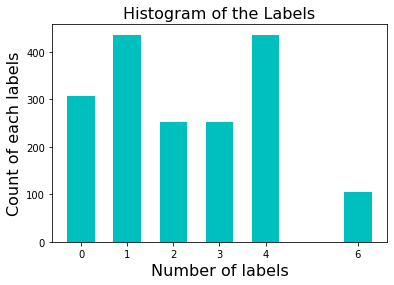

In [ ]:
# Histogram of the classes
plt.bar(unique_labels, unique_labels_counts,align = 'center', width=0.6, color = 'c')
plt.xlabel('Number of labels', fontsize=16)
plt.xticks(unique_labels)
plt.ylabel('Count of each labels', fontsize=16)
plt.title('Histogram of the Labels', fontsize=16)
plt.show()

# 5. Data Pre-Processing

### Getting the features of audio files using librosa

Calculating MFCC, Pitch, magnitude, Chroma features.

In [1]:
#from utils.feature_extraction import get_features_dataframe
#from utils.feature_extraction import get_audio_features

To know more about "get_features_dataframe" and "get_audio_features" functions and their working, go to "./utils/feature_extraction.py" script. 

In [ ]:

# trainfeatures, trainlabel = get_features_dataframe(train_df, sampling_rate)
# testfeatures, testlabel = get_features_dataframe(test_df, sampling_rate)

# I have ran above 2 lines and get the featured dataframe. 
# and store it into pickle file to use it for later purpose.
# it take too much time to generate features(around 30-40 minutes).

trainfeatures = pd.read_pickle('/content/drive/MyDrive/Emotion Speech Recognition/features_dataframe/trainfeatures')
trainlabel = pd.read_pickle('/content/drive/MyDrive/Emotion Speech Recognition/features_dataframe/trainlabel')
testfeatures = pd.read_pickle('/content/drive/MyDrive/Emotion Speech Recognition/features_dataframe/testfeatures')
testlabel = pd.read_pickle('/content/drive/MyDrive/Emotion Speech Recognition/features_dataframe/testlabel')

In [ ]:
trainfeatures.shape

(2044, 65)

In [ ]:
trainfeatures = trainfeatures.fillna(0)
testfeatures = testfeatures.fillna(0)

In [ ]:
# By using .ravel() : Converting 2D to 1D e.g. (512,1) -> (512,). To prevent DataConversionWarning

X_train = np.array(trainfeatures)
y_train = np.array(trainlabel).ravel()
X_test = np.array(testfeatures)
y_test = np.array(testlabel).ravel()


In [ ]:
y_train[:5]

array([3, 2, 2, 0, 3])

In [ ]:
# One-Hot Encoding
lb = LabelEncoder()

y_train = np_utils.to_categorical(lb.fit_transform(y_train))
y_test = np_utils.to_categorical(lb.fit_transform(y_test))

In [ ]:
y_train[:5]

array([[0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0.]], dtype=float32)

### Changing dimension for CNN model

In [ ]:
x_traincnn =np.expand_dims(X_train, axis=2)
x_testcnn= np.expand_dims(X_test, axis=2)

In [ ]:
x_traincnn.shape

(2044, 65, 1)

# 6. Model Creation

In [ ]:
from tensorflow.keras import optimizers

In [ ]:
model = Sequential()

model.add(Conv1D(256, 5,padding='same',
                 input_shape=(x_traincnn.shape[1],x_traincnn.shape[2])))
model.add(Activation('relu'))
model.add(Conv1D(128, 5,padding='same'))
model.add(Activation('relu'))
model.add(Dropout(0.1))
model.add(MaxPooling1D(pool_size=(8)))
model.add(Conv1D(128, 5,padding='same',))
model.add(Activation('relu'))
model.add(Conv1D(128, 5,padding='same',))
model.add(Activation('relu'))
model.add(Flatten())
model.add(Dense(y_train.shape[1]))
model.add(Activation('softmax'))
opt = keras.optimizers.RMSprop(lr=0.00001, decay=1e-6)

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/rmsprop.py:135: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 65, 256)           1536      
                                                                 
 activation (Activation)     (None, 65, 256)           0         
                                                                 
 conv1d_1 (Conv1D)           (None, 65, 128)           163968    
                                                                 
 activation_1 (Activation)   (None, 65, 128)           0         
                                                                 
 dropout (Dropout)           (None, 65, 128)           0         
                                                                 
 max_pooling1d (MaxPooling1D  (None, 8, 128)           0         
 )                                                               
                                                        

In [ ]:
model.compile(loss='categorical_crossentropy', optimizer=opt,metrics=['accuracy'])

# 7. Training and Evaluation

### Removed the whole training part for avoiding unnecessary long epochs list

In [ ]:
cnnhistory=model.fit(x_traincnn, y_train, batch_size=16, epochs=370, validation_data=(x_testcnn, y_test))

Epoch 1/370
128/128 [==============================] - 8s 51ms/step - loss: 2.1399 - accuracy: 0.2275 - val_loss: 1.8425 - val_accuracy: 0.2598
Epoch 2/370
128/128 [==============================] - 6s 49ms/step - loss: 1.8603 - accuracy: 0.2476 - val_loss: 1.7647 - val_accuracy: 0.3125
Epoch 3/370
128/128 [==============================] - 6s 48ms/step - loss: 1.7711 - accuracy: 0.2852 - val_loss: 1.7198 - val_accuracy: 0.3223
Epoch 4/370
128/128 [==============================] - 6s 48ms/step - loss: 1.7405 - accuracy: 0.3126 - val_loss: 1.7097 - val_accuracy: 0.3203
Epoch 5/370
128/128 [==============================] - 6s 49ms/step - loss: 1.7005 - accuracy: 0.3239 - val_loss: 1.6760 - val_accuracy: 0.3320
Epoch 6/370
128/128 [==============================] - 6s 48ms/step - loss: 1.6511 - accuracy: 0.3581 - val_loss: 1.6702 - val_accuracy: 0.3145
Epoch 7/370
128/128 [==============================] - 6s 49ms/step - loss: 1.6251 - accuracy: 0.3620 - val_loss: 1.6204 - val_accuracy:

### Loss Vs Iterations

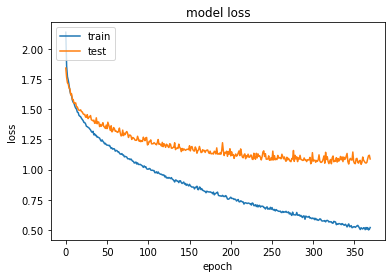

In [ ]:
plt.plot(cnnhistory.history['loss'])
plt.plot(cnnhistory.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

### Saving the model

In [ ]:
model_name = 'omar2.h5'
save_dir = os.path.join(os.getcwd(), 'Trained_Models')
# Save model and weights
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
model_path = os.path.join('/content/drive/MyDrive/Emotion Speech Recognition/Trained_Models', model_name)
model.save(model_path)
print('Saved trained model at %s ' % model_path)

Saved trained model at /content/drive/MyDrive/Emotion Speech Recognition/Trained_Models/omar2.h5 


In [ ]:
import json
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)

### Loading the model

In [ ]:
# loading json and creating model
from keras.models import model_from_json
json_file = open('model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("/content/drive/MyDrive/Emotion Speech Recognition/Trained_Models/omar2.h5")
print("Loaded model from disk")
 
# evaluate loaded model on test data
loaded_model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
score = loaded_model.evaluate(x_testcnn, y_test, verbose=0)
print("%s: %.2f%%" % (loaded_model.metrics_names[1], score[1]*100))

Loaded model from disk
accuracy: 59.18%


# 8. Test Set Prediction

### Predicting emotions on the test data

In [ ]:
preds = loaded_model.predict(x_testcnn, 
                         batch_size=32, 
                         verbose=1)

16/16 [==============================] - 0s 20ms/step


In [ ]:
preds

array([[2.6048318e-01, 1.6441054e-03, 6.8255091e-01, ..., 1.1878190e-02,
        9.7016094e-04, 3.8663793e-02],
       [8.5572761e-01, 5.0621212e-04, 5.2677441e-02, ..., 3.0645687e-04,
        2.1122040e-02, 1.6500630e-03],
       [2.0173240e-02, 6.8754017e-01, 6.9195228e-03, ..., 2.4611710e-01,
        1.9000662e-02, 1.8123100e-02],
       ...,
       [3.9218520e-03, 9.1838077e-02, 8.2072389e-01, ..., 4.0268146e-02,
        2.9934062e-02, 7.7401302e-03],
       [3.3480920e-02, 1.7998667e-04, 2.4537472e-01, ..., 4.2964628e-05,
        4.2227390e-01, 5.0408489e-05],
       [3.8345806e-02, 1.2611125e-01, 1.1506513e-01, ..., 6.9934507e-03,
        1.0993632e-02, 5.8359820e-01]], dtype=float32)

In [ ]:
preds1=preds.argmax(axis=1)

In [ ]:
preds1

array([2, 0, 1, 3, 3, 6, 6, 5, 3, 5, 2, 4, 0, 4, 4, 3, 2, 5, 1, 5, 2, 4,
       6, 4, 0, 3, 0, 2, 3, 3, 3, 4, 5, 3, 1, 3, 5, 3, 2, 3, 4, 6, 4, 0,
       5, 1, 1, 5, 0, 5, 1, 3, 2, 5, 4, 5, 2, 2, 5, 4, 4, 0, 4, 5, 0, 3,
       5, 2, 0, 3, 3, 2, 4, 2, 4, 5, 5, 6, 0, 1, 5, 0, 0, 2, 5, 3, 6, 0,
       5, 2, 3, 0, 4, 2, 2, 6, 6, 5, 4, 5, 2, 4, 5, 5, 3, 5, 5, 3, 6, 3,
       2, 3, 0, 3, 4, 5, 5, 5, 5, 0, 5, 3, 6, 2, 0, 5, 6, 2, 5, 4, 5, 5,
       1, 3, 4, 0, 3, 0, 5, 4, 0, 0, 1, 2, 0, 0, 5, 5, 4, 5, 5, 1, 4, 0,
       5, 4, 4, 0, 3, 5, 0, 5, 5, 5, 0, 3, 4, 4, 6, 6, 6, 5, 6, 4, 6, 4,
       2, 4, 5, 5, 1, 0, 4, 5, 2, 5, 2, 2, 1, 0, 5, 0, 4, 6, 4, 1, 0, 6,
       5, 0, 0, 2, 5, 4, 4, 3, 4, 6, 0, 4, 3, 3, 2, 2, 1, 4, 4, 6, 3, 4,
       5, 4, 0, 3, 4, 4, 1, 5, 5, 0, 5, 4, 4, 4, 0, 2, 4, 5, 1, 6, 6, 4,
       5, 2, 4, 5, 5, 2, 5, 0, 1, 4, 0, 5, 2, 1, 1, 5, 1, 4, 3, 5, 4, 4,
       2, 6, 5, 5, 0, 2, 5, 4, 6, 4, 4, 3, 2, 5, 0, 0, 2, 2, 5, 0, 1, 5,
       3, 4, 5, 5, 5, 3, 4, 6, 5, 0, 2, 5, 4, 0, 5,

In [ ]:
abc = preds1.astype(int).flatten()

In [ ]:
predictions = (lb.inverse_transform((abc)))

In [ ]:
#summary visualization

from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, classification_report
results = confusion_matrix(y_test, preds1)
print('Confusion Matrix')
print(results)
print('Accuracy Score :',accuracy_score(x_testcnn, preds))
print('Report')
print(classification_report(x_testcnn, preds))

ValueError: ignored

In [ ]:
preddf = pd.DataFrame({'predictedvalues': predictions})
preddf[:10]

,predictedvalues
0,2
1,0
2,1
3,3
4,3
5,6
6,6
7,5
8,3
9,5


In [ ]:
actual=y_test.argmax(axis=1)
abc123 = actual.astype(int).flatten()
actualvalues = (lb.inverse_transform((abc123)))

In [ ]:
actualdf = pd.DataFrame({'actualvalues': actualvalues})
actualdf[:10]

,actualvalues
0,2
1,0
2,1
3,2
4,3
5,6
6,6
7,5
8,3
9,5


In [ ]:
finaldf = actualdf.join(preddf)

## Actual v/s Predicted emotions

In [ ]:
finaldf[120:130]

,actualvalues,predictedvalues
120,5,5
121,3,3
122,3,6
123,0,0
124,1,0
125,5,5
126,6,4
127,2,2
128,5,5
129,1,6


In [ ]:
finaldf.groupby('actualvalues').count()

,predictedvalues
actualvalues,
0,81
1,60
2,83
3,85
4,53
5,97
6,53


In [ ]:
finaldf.groupby('predictedvalues').count()

,actualvalues
predictedvalues,
0,108
1,34
2,55
3,58
4,73
5,124
6,60


In [ ]:
finaldf.to_csv('Predictions.csv', index=False)

# 9. Live Demonstration

#### The file 'output10.wav' in the next cell is the file that was recorded live using the code in AudioRecoreder notebook found in the repository

In [ ]:
demo_audio_path = '/content/drive/MyDrive/Emotion Speech Recognition/demo_audio.wav'
ipd.Audio('/content/drive/MyDrive/Emotion Speech Recognition/demo_audio.wav')

In [ ]:
###
#with open('/content/drive/MyDrive/Emotion Speech Recognition/utils/feature_extraction.py', "r") as f:
    #get_audio_features = f.read()
    #print(get_audio_features)

In [ ]:
# feature_extracting
import librosa
import pandas as pd
import numpy as np

def get_audio_features(audio_path,sampling_rate):
    X, sample_rate = librosa.load(audio_path ,res_type='kaiser_fast',duration=2.5,sr=sampling_rate*2,offset=0.5)
    sample_rate = np.array(sample_rate)

    y_harmonic, y_percussive = librosa.effects.hpss(X)
    pitches, magnitudes = librosa.core.pitch.piptrack(y=X, sr=sample_rate)

    mfccs = np.mean(librosa.feature.mfcc(y=X,sr=sample_rate,n_mfcc=13),axis=1)

    pitches = np.trim_zeros(np.mean(pitches,axis=1))[:20]

    magnitudes = np.trim_zeros(np.mean(magnitudes,axis=1))[:20]

    C = np.mean(librosa.feature.chroma_cqt(y=y_harmonic, sr=sampling_rate),axis=1)
    
    return [mfccs, pitches, magnitudes, C]
    
    

def get_features_dataframe(dataframe, sampling_rate):
    labels = pd.DataFrame(dataframe['label'])
    
    features  = pd.DataFrame(columns=['mfcc','pitches','magnitudes','C'])
    for index, audio_path in enumerate(dataframe['path']):
        features.loc[index] = get_audio_features(audio_path, sampling_rate)
    
    mfcc = features.mfcc.apply(pd.Series)
    pit = features.pitches.apply(pd.Series)
    mag = features.magnitudes.apply(pd.Series)
    C = features.C.apply(pd.Series)
    
    combined_features = pd.concat([mfcc,pit,mag,C],axis=1,ignore_index=True)

    return combined_features, labels 

In [ ]:
demo_mfcc, demo_pitch, demo_mag, demo_chrom = get_audio_features(demo_audio_path,sampling_rate)

mfcc = pd.Series(demo_mfcc)
pit = pd.Series(demo_pitch)
mag = pd.Series(demo_mag)
C = pd.Series(demo_chrom)
demo_audio_features = pd.concat([mfcc,pit,mag,C],ignore_index=True)

In [ ]:
demo_audio_features= np.expand_dims(demo_audio_features, axis=0)
demo_audio_features= np.expand_dims(demo_audio_features, axis=2)

In [ ]:
demo_audio_features.shape

(1, 65, 1)

In [ ]:
livepreds = loaded_model.predict(demo_audio_features, 
                         batch_size=32, 
                         verbose=1)

1/1 [==============================] - 0s 113ms/step


In [ ]:
livepreds

array([[0.86553067, 0.00282961, 0.07553351, 0.00326534, 0.00384086,
        0.01968454, 0.02931549]], dtype=float32)

In [ ]:
# emotions=["anger","disgust","fear","happy","neutral", "sad", "surprise"]
index = livepreds.argmax(axis=1).item()
index

0

In [ ]:
emotions[index]

'anger'